In [1]:
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import dgl.nn as dglnn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from mutagDataset_2 import MUTAG

In [2]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

data = MUTAG()

num_examples = len(data)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    data, sampler=train_sampler)
test_dataloader = GraphDataLoader(
    data, sampler=test_sampler)

In [3]:
class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')
        
    def forward(self, graph, inputs):
        # inputs is features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.normalize(v) for k, v in h.items()}
        h = {k: F.relu(v) for k, v in h.items()}
        
        h = self.conv2(graph, h)
        h = {k: F.dropout(v, p=0.3) for k, v in h.items()}
        return h

class HeteroClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes, rel_names):
        super().__init__()
        self.in_dim = in_dim
        self.rgcn = RGCN(in_dim, hidden_dim, hidden_dim, rel_names)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        h = {ntype:torch.zeros((g.num_nodes(ntype), self.in_dim)) for ntype in g.ntypes}
        
        h = self.rgcn(g, h)

        with g.local_scope():
            g.ndata['h'] = h
            # Calculate graph representation by average readout.
            hg = 0
            for ntype in g.ntypes:
                hg = hg + dgl.mean_nodes(g, 'h', ntype=ntype)
            return self.classify(hg)


In [4]:
rel_names = set()

for graph in data:
    for edge in graph[0].etypes:
        rel_names.add(str(edge))

rel_names = list(rel_names)

In [5]:
model = HeteroClassifier(10, 20, 2, rel_names)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.015)

training_loss = []
for epoch in range(50):
    num_correct, num_tests = 0, 0
    for batched_graph, labels in train_dataloader:
        logits = model(batched_graph)
        loss = F.cross_entropy(logits, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        num_correct += (logits.argmax(1) == labels).sum().item()
        num_tests += len(labels)
    training_loss.append(loss)
    if epoch % 5 == 0:
        print(f'Epochs {epoch}, Train accuracy: {num_correct / num_tests * 100:.2f}%')
    
    
num_correct, num_tests = 0, 0    
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph)
    num_correct += (logits.argmax(1) == labels).sum().item()
    num_tests += len(labels)
        
print(f'Test accuracy: {num_correct / num_tests * 100:.2f}%')

/Users/tk178/opt/anaconda3/envs/torchenv/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


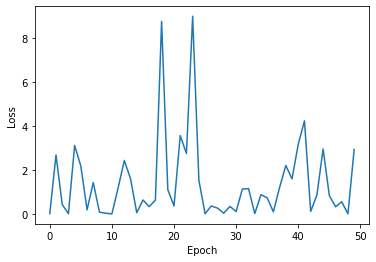

In [159]:
import matplotlib.pyplot as plt

plt.plot(training_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()